In [10]:
from deep_translator import GoogleTranslator
from folium.features import GeoJsonTooltip
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.font_manager
import geopandas as gpd
import folium.plugins
import pandas as pd
import numpy as np
import folium as f
import openpyxl
import json
import os

# import import_ipynb
# from imports import *

%matplotlib inline

def write_csv(df, path):
    df.to_csv(path, index=True, header=True)
    
def open_csv(path):
    return pd.read_csv(path)

def open_json(path):
    return json.load(open(path))

def get_date():
    return str(dt.now().strftime("%Y-%m-%d")) #-%H-%M-%S

def save_map(m):
    m.save(f"{output_path}\map.html")

def save_plot(plt, direction):
    return "Image saved" if plt.savefig(f'{output_path}\\{direction}barplot_{get_date()}.png', dpi=1200, bbox_inches='tight') else None

def set_output(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
        return True

output_path = f'output/brahiam'
set_output(output_path)
geojson_path = 'maps/world/world-administrative-boundaries.geojson'
save_path = f'{output_path}/countries_imports.csv'

In [ ]:
# Reading
path = 'raw_data/Perfil_EmpresasImpo_2022_WEB.xlsx'
df = pd.read_excel(path, engine='openpyxl')

In [ ]:
# Cleaning 
df = pd.DataFrame(df['País_origen'].value_counts())
df.dropna()

# Modificaré las columnas con rename(), así que no coloco los países como índices.
df = df.reset_index()

# Filtering
# mask = (df['País_origen'] == 'Sin información') | (df['País_origen'] == 'República Dominicana')
df = df[~mask]
df.rename(columns={"País_origen":"Country", "count":"Total_imports"}, inplace=True)
df

In [ ]:
# Country column translation in order to match geojson countries for displaying the data on the map.
df['Country'] = df['Country'].apply(lambda x: str(GoogleTranslator(source='es', target='en').translate(x)))
df['Country'] = df['Country'].replace(['The Savior', 'Türkiye', 'United Kingdom'], ['El Salvador', 'Turkey', 'U.K. of Great Britain and Northern Ireland'])
df['Country'] = df['Country'].apply(lambda x: str(x.split('(')[0].strip()))

# Setting Country as the DataFrame index.
df.set_index('Country', inplace=True)

# Saving processed data
write_csv(df, save_path)

df

In [5]:
# Ahora trabajaré con la data procesada.
df = open_csv(save_path)
df.set_index('Country', inplace=True)

# Organizamos la data de manera descendente.
df = df.sort_values(by='Total_imports', ascending=False)
df

,Total_imports
Country,
China,203794
United States of America,154279
Spain,25455
Italy,17690
Mexico,17593
...,...
Tuvalu,1
Mali,1
South Georgia and the South Sandwich Islands,1


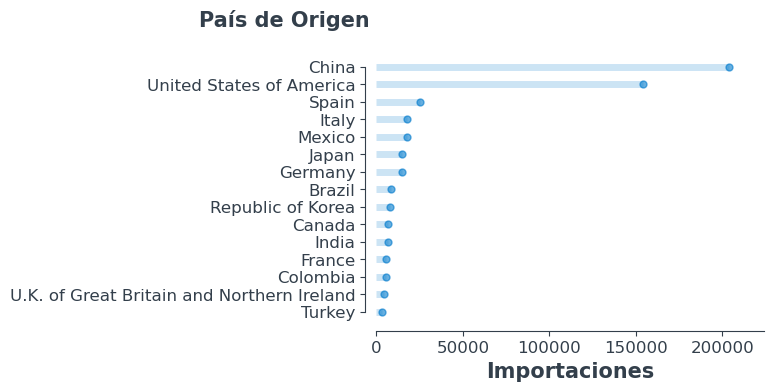

In [11]:
# Ordenamos de manera ascendente para graficar de abajo hacia arriba.
plot_lim = 15
bp = df[:plot_lim] # Top 15 | x -> plot_lim
bp = bp.sort_values(by='Total_imports', ascending=True)

xlabel = 'Importaciones'
ylabel = 'País de Origen'

# Spliting data for x and y.
names = bp.index
values = bp['Total_imports']
lim = values[-1] * 1.1

# Setting font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# Set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# Numeric placeholder for the y axis
my_range=list(range(1, len(bp.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))

# Create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=values, color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(values, my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel(xlabel, fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, bp.index)

# add an horizonal label for the y axis 
fig.text(-0.23, 0.96, ylabel, fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1, len(my_range)))
ax.set_xlim(0, lim)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

In [ ]:
save_plot(fig, 'h')

In [ ]:
print("Total de paises que importaron a República Dominicana en 2022:", len(df.index)) 

In [ ]:
df = df.reset_index()

In [ ]:
center = [35.762887,84.083132]
mapa = f.Map(location=center, zoom_start=1.6,
            min_zoom=1, max_bounds=True,
            min_lat=-84, min_lon=-175,
            max_lat=84,  max_lon=187,
            control_scale=True,
            tiles="openstreetmap" # cartodb positron
    )

data_geojson = open_json(geojson_path)

# Assuming that data_geojson is a dictionary containing the GeoJSON data
gpd_geo = gpd.GeoDataFrame.from_features(data_geojson)

# Merge the GeoJSON data with df
gpd_geo = gpd_geo.merge(df, left_on='name', right_on='Country')

# Create a Choropleth layer with the merged data
choropleth = f.Choropleth(
    geo_data=gpd_geo.__geo_interface__,
    name = 'Importaciones',
    data=df,
    columns=['Country', 'Total_imports'],
    key_on='feature.properties.name',
    fill_color='Pastel2', 
    fill_opacity=0.7, 
    line_opacity=0.1,
    legend_name='Países importadores hacia República Dominicana (2022)',
    nan_fill_color='gray',
    line_color = "#0000",
    reset=True,
    highlight=True,
).add_to(mapa)

# Add tooltips to the Choropleth layer
choropleth.geojson.add_child(
    GeoJsonTooltip(fields=['Country', 'Total_imports'],
                   aliases=['País: ', 'Importaciones: '],
                   labels=True,
                   localize=True,
                   sticky=False)
)

f.plugins.Fullscreen(
    position="topright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(mapa)

f.LayerControl().add_to(mapa)
mapa

In [ ]:
save_map(mapa)